In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import osmnx as ox
import pandas as pd
import pickle
import tensorflow as tf

In [2]:
tf.__version__

'1.12.0'

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load the model
Load the training supposed best training checkpoint.

In [4]:
DATASET_NAME = 'cabspotting'
G_GRU_SIZE = 32
D_GRU_SIZE = 16

g_string = 'g_GRU-{g_gru_size}_rand-32_Dense-3_adam_bce_default_'.format(g_gru_size=G_GRU_SIZE)
d_string = 'd_gin_GRU-{d_gru_size}_Dense-1_adam_bce_default_'.format(d_gru_size=D_GRU_SIZE)
setup_string = g_string + d_string + '{dataset}_64_100'.format(dataset=DATASET_NAME)

In [5]:
setup_string

'g_GRU-32_rand-32_Dense-3_adam_bce_default_d_gin_GRU-16_Dense-1_adam_bce_default_cabspotting_64_100'

In [6]:
history = pickle.load(open('histories/citybased_gan_2/' + setup_string + '_30.pkl', 'rb'))

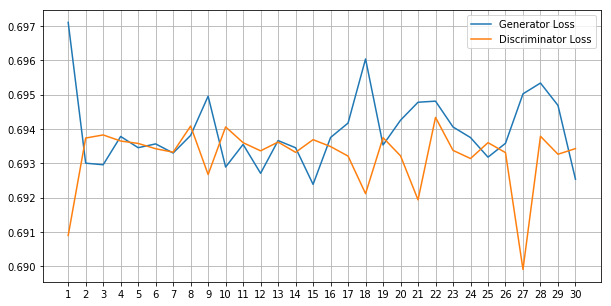

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 31, 1), history['g_loss'], label='Generator Loss')
plt.plot(np.arange(1, 31, 1), history['d_loss'], label='Discriminator Loss')
plt.xticks(np.arange(1, 31, 1))
plt.grid()
plt.legend()
plt.show()

In [8]:
SELECTED_EPOCH = 30

In [9]:
# Load the model
model_path = 'checkpoints/citybased_gan_2/' + setup_string + '_{:02d}_g.h5'.format(SELECTED_EPOCH)
model = tf.keras.models.load_model(model_path)

## Actual generation

In [10]:
N_USERS = 3

Generate user start positions

In [11]:
poskde = pickle.load(open('../data_{dataset}/poskde_{dataset}_000003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [12]:
startpositions = poskde.sample(N_USERS)

In [13]:
startpositions[:3]

array([[-122.41944375,   37.75214122],
       [-122.42205481,   37.79037368],
       [-122.4107028 ,   37.77961261]])

Generate start and end times

In [14]:
real_dataset = pd.read_pickle('../data_{dataset}/{dataset}_cut.pkl'.format(dataset=DATASET_NAME))
print('Real begin: {}'.format(real_dataset.index.levels[1].min()))
print('Real end: {}'.format(real_dataset.index.levels[1].max()))
del real_dataset

Real begin: 2008-06-02 00:00:00
Real end: 2008-06-08 23:59:59


In [15]:
BEGIN = pd.Timestamp('2008-06-02 00:00:00')
END = pd.Timestamp('2008-06-08 23:59:59')
total_duration = END - BEGIN
print(total_duration)

6 days 23:59:59


In [16]:
sekde = pickle.load(open('../data_{dataset}/sekde_{dataset}_cut_003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [17]:
starttimes = np.full(N_USERS, -1.0)
out_of_range = (starttimes < 0) | (starttimes >= 1.0)

while np.any(out_of_range):
    new_samples = np.squeeze(sekde['kde_start'].sample(len(starttimes[out_of_range])))
    starttimes[out_of_range] = new_samples
    out_of_range = (starttimes < 0) | (starttimes >= 1.0)

In [18]:
starttimes[:3]

array([0.02286434, 0.04082827, 0.02126994])

In [19]:
durations = np.zeros(N_USERS)
out_of_range = (durations <= 0) | (starttimes + durations > 1.0)

while np.any(out_of_range):
    new_samples = np.squeeze(sekde['kde_duration'].sample(len(durations[out_of_range])))
    durations[out_of_range] = new_samples
    out_of_range = (durations <= 0) | (starttimes + durations > 1.0)

In [20]:
durations[:3]

array([0.9545139 , 0.95480302, 0.53987599])

In [21]:
starttimes = starttimes * total_duration.total_seconds()
starttimes[:3]

array([13828.32965317, 24692.89413205, 12864.03931229])

In [22]:
durations = durations * total_duration.total_seconds()
durations[:3]

array([577289.05012905, 577463.91309912, 326516.45986991])

In [23]:
starts = np.concatenate([starttimes.reshape(-1, 1), startpositions], axis=1)

In [24]:
starts[:3]

array([[13828.32965317,  -122.41944375,    37.75214122],
       [24692.89413205,  -122.42205481,    37.79037368],
       [12864.03931229,  -122.4107028 ,    37.77961261]])

In [25]:
scaler = pickle.load(open('scalers/citybased_gan_2/' + setup_string + '.pkl', 'rb'))

Actual generation loops

In [26]:
ninety_seconds = scaler.transform(np.array([[90.0, 0.0, 0.0]]))[0, 0]
ninety_seconds

-0.0006995799171646498

In [27]:
def generate_user(generator, scaler, start, duration):
    sc = np.array([start])
    s = sc.copy()
    s[0, 0] = 0.0
    s = scaler.transform(s)   
    
    starttime = start[0]
    endtime = starttime + duration
    
    while(sc[-1, 0] <= endtime):        
        x = s[-100:]
        noise = np.random.rand(32)
        
        y = model.predict([x.reshape(1, -1, 3), noise.reshape(1, 32)]).squeeze()
        y[0] = max(ninety_seconds, y[0])
        
        s = np.concatenate([s, y.reshape((1, 3))])
        
        yc = scaler.inverse_transform(y.reshape(1, 3)).squeeze()
        yc[0] = sc[-1, 0] + yc[0]
        
        sc = np.concatenate([sc, yc.reshape((1, 3))])
        
        #print('\r{}'.format(sc[-1, 0] - sc[-2, 0]), end='')
    
    return sc[:-1]

In [28]:
data = []
for u in range(N_USERS):
    print(u)
    s = generate_user(model, scaler, starts[u], durations[u])
    data.append(s)

0
1
2


Inspect generated data

In [31]:
i = 2

In [32]:
data[i]

array([[ 1.28640393e+04, -1.22410703e+02,  3.77796126e+01],
       [ 1.30437617e+04, -1.22406601e+02,  3.77709122e+01],
       [ 1.31337617e+04, -1.22402023e+02,  3.77650452e+01],
       ...,
       [ 3.39129125e+05, -1.22130234e+02,  3.79780350e+01],
       [ 3.39219125e+05, -1.22130348e+02,  3.79778442e+01],
       [ 3.39309125e+05, -1.22130470e+02,  3.79784508e+01]])

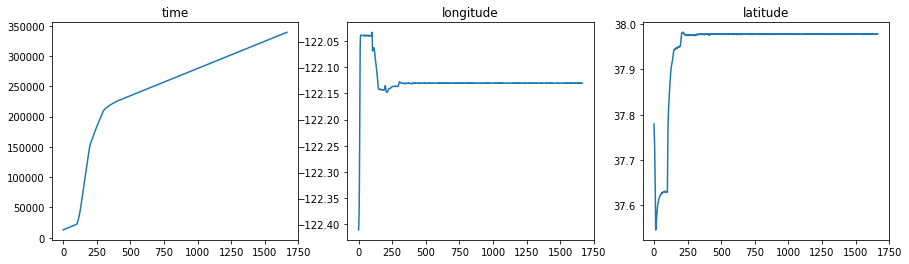

In [33]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(data[i][:, 0])
plt.title('time')
plt.subplot(132)
plt.plot(data[i][:, 1])
plt.title('longitude')
plt.subplot(133)
plt.plot(data[i][:, 2])
plt.title('latitude')
plt.show()

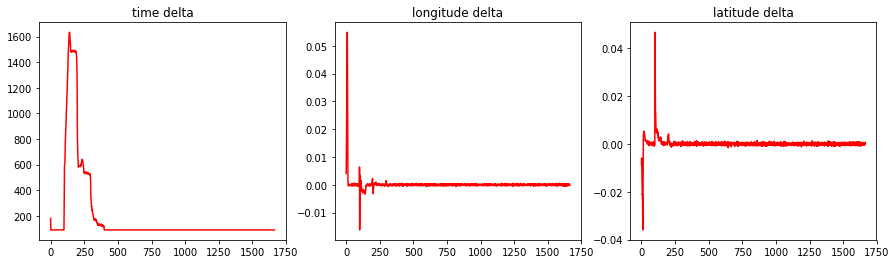

In [34]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(np.diff(data[i][:, 0]), c='red')
plt.title('time delta')
plt.subplot(132)
plt.plot(np.diff(data[i][:, 1]), c='red')
plt.title('longitude delta')
plt.subplot(133)
plt.plot(np.diff(data[i][:, 2]), c='red')
plt.title('latitude delta')
plt.show()

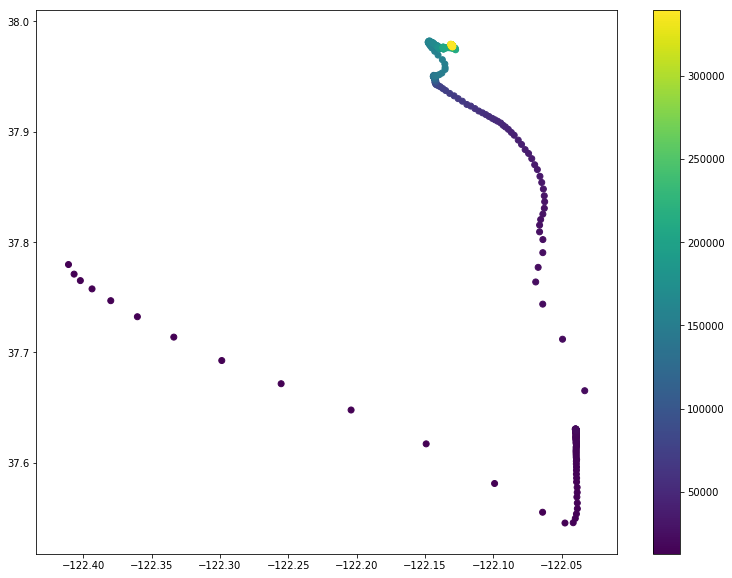

In [35]:
plt.figure(figsize=(13, 10))
plt.scatter(data[i][:, 1], data[i][:, 2], c=data[i][:, 0])
plt.colorbar()
plt.show()

## Convert data to standard format

In [36]:
dfs = []
for u in range(len(data)):
    userdf = pd.DataFrame(data[u], columns=['time', 'longitude', 'latitude'])
    userdf['user'] = u
    userdf['time'] = BEGIN + pd.to_timedelta(userdf['time'], unit='s')
    dfs.append(userdf)

df = pd.concat(dfs, ignore_index=True)
df = df.set_index(['user', 'time'])

df.head()

longitude   latitude
user time                                                
0    2008-06-02 03:50:28.329653167 -122.419444  37.752141
     2008-06-02 03:55:54.195312500 -122.417740  37.735115
     2008-06-02 03:59:35.500976561 -122.415184  37.716423
     2008-06-02 04:01:28.405273438 -122.408539  37.696045
     2008-06-02 04:02:58.405273438 -122.396561  37.672443

In [37]:
df.to_pickle('generated/citybased_gan_2/' + setup_string + '_cut.pkl')